In [1]:
import torch
import torch.utils.data as data
import pandas as pd
import matplotlib.pyplot as plt
from src.error_measures import get_accuracy, get_error_measures, collect_stats, print_average_stats, gather_predictions
from src.models import MultiLayerANN, SynapticSNN, LeakySNN, DoubleLeakySNN
from src.train_model import training_loop

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Data

In [3]:
data06 = pd.read_csv("../data/processed/target06.csv")
data06.drop(columns=["weekday"], inplace=True)

In [4]:
all_data = data.TensorDataset(torch.from_numpy((data06.values[:,:-1] - data06.values[:,:-1].min(0)) / data06.values[:,:-1].ptp(0)).float(),
                              torch.from_numpy(data06.values[:,-1]).float())  # with normalization
train_dataset, test_dataset, valid_dataset = torch.utils.data.random_split(all_data, (round(0.75 * len(all_data)), round(0.15 * len(all_data)), round(0.1 * len(all_data))))

In [5]:
train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False)
valid_loader = data.DataLoader(valid_dataset, batch_size=256, shuffle=False, drop_last=False)

### Simple regressor

In [7]:
model1 = MultiLayerANN(num_inputs=8, num_hidden=5000, num_outputs=1)
print(model1)

MultiLayerANN(
  (lin1): Linear(in_features=8, out_features=5000, bias=True)
  (sigmoid): Sigmoid()
  (lin2): Linear(in_features=5000, out_features=5000, bias=True)
  (relu): LeakyReLU(negative_slope=0.01)
  (lin3): Linear(in_features=5000, out_features=1, bias=True)
)


In [9]:
training_loop(model1, train_loader, valid_loader, device, num_epochs=20, lr=0.003, validation=True, collect=True)

  5%|▌         | 1/20 [00:03<01:03,  3.35s/it]

MAE: 7.4518, MSE:94.7127,
RMSE: 9.7320, IA: 0.8678, MAPE: 56.2570%
3.351243495941162


 10%|█         | 2/20 [00:06<00:56,  3.16s/it]

MAE: 7.6082, MSE:98.9675,
RMSE: 9.9482, IA: 0.8658, MAPE: 57.7676%
6.382479906082153


 15%|█▌        | 3/20 [00:09<00:52,  3.09s/it]

MAE: 7.1147, MSE:100.3814,
RMSE: 10.0191, IA: 0.8621, MAPE: 38.4200%
9.39168667793274


 20%|██        | 4/20 [00:12<00:49,  3.08s/it]

MAE: 6.6970, MSE:87.5081,
RMSE: 9.3546, IA: 0.8819, MAPE: 42.8369%
12.446910619735718


 25%|██▌       | 5/20 [00:15<00:46,  3.07s/it]

MAE: 7.0790, MSE:90.1536,
RMSE: 9.4949, IA: 0.8527, MAPE: 51.8631%
15.513137340545654


 30%|███       | 6/20 [00:18<00:43,  3.08s/it]

MAE: 6.6749, MSE:86.5561,
RMSE: 9.3036, IA: 0.8654, MAPE: 44.9387%
18.61936664581299


 35%|███▌      | 7/20 [00:21<00:39,  3.07s/it]

MAE: 6.5655, MSE:86.8565,
RMSE: 9.3197, IA: 0.8795, MAPE: 40.6446%
21.644598484039307


 40%|████      | 8/20 [00:24<00:36,  3.08s/it]

MAE: 7.0392, MSE:90.0675,
RMSE: 9.4904, IA: 0.8747, MAPE: 50.6564%
24.75081443786621


 45%|████▌     | 9/20 [00:27<00:34,  3.12s/it]

MAE: 7.1953, MSE:90.3743,
RMSE: 9.5065, IA: 0.8630, MAPE: 53.7312%
27.94804883003235


 50%|█████     | 10/20 [00:30<00:30,  3.09s/it]

MAE: 6.7492, MSE:86.2155,
RMSE: 9.2852, IA: 0.8737, MAPE: 46.5116%
30.982271909713745


 55%|█████▌    | 11/20 [00:33<00:27,  3.06s/it]

MAE: 6.6479, MSE:84.9071,
RMSE: 9.2145, IA: 0.8777, MAPE: 44.7954%
33.97249126434326


 60%|██████    | 12/20 [00:36<00:24,  3.04s/it]

MAE: 8.1531, MSE:107.3136,
RMSE: 10.3592, IA: 0.8548, MAPE: 64.5040%
36.9667112827301


 65%|██████▌   | 13/20 [00:39<00:21,  3.02s/it]

MAE: 6.5867, MSE:86.2793,
RMSE: 9.2887, IA: 0.8704, MAPE: 42.1363%
39.9479296207428


 70%|███████   | 14/20 [00:42<00:18,  3.02s/it]

MAE: 6.6260, MSE:85.3400,
RMSE: 9.2380, IA: 0.8812, MAPE: 44.0004%
42.95215106010437


 75%|███████▌  | 15/20 [00:45<00:15,  3.00s/it]

MAE: 7.3018, MSE:104.6237,
RMSE: 10.2286, IA: 0.8581, MAPE: 38.2584%
45.918368101119995


 80%|████████  | 16/20 [00:48<00:11,  2.99s/it]

MAE: 7.7135, MSE:97.7544,
RMSE: 9.8871, IA: 0.8491, MAPE: 60.1875%
48.89258623123169


 85%|████████▌ | 17/20 [00:51<00:08,  2.99s/it]

MAE: 7.2874, MSE:93.4876,
RMSE: 9.6689, IA: 0.8732, MAPE: 54.0030%
51.85880446434021


 90%|█████████ | 18/20 [00:54<00:06,  3.03s/it]

MAE: 6.5660, MSE:84.8094,
RMSE: 9.2092, IA: 0.8775, MAPE: 42.4266%
54.979034662246704


 95%|█████████▌| 19/20 [00:58<00:03,  3.07s/it]

MAE: 6.6048, MSE:87.3846,
RMSE: 9.3480, IA: 0.8723, MAPE: 40.3246%
58.14826822280884


100%|██████████| 20/20 [01:01<00:00,  3.06s/it]

MAE: 7.4268, MSE:105.7237,
RMSE: 10.2822, IA: 0.8558, MAPE: 39.0856%
61.202492237091064
Accuracy on validation dataset: 38.84%


In [8]:
print(f'Accuracy on test set: {get_accuracy(model1, test_loader, device=device, pct_close=0.25)*100}%')
get_error_measures(model1, test_loader, device=device, print_e=True)

Accuracy on test set: 47.53%
MAE: 6.4587, MSE:85.0346,
RMSE: 9.2214, IA: 0.8878, MAPE: 43.5864%


(6.458659489276045,
 85.03464193936645,
 9.221422988854076,
 0.8878055511216513,
 43.586442388997)

### SNN with Leaky layer

In [11]:
thr2 = torch.full([4000], 0.9).to(device)
model2 = LeakySNN(num_inputs=8, num_hidden=4000, num_outputs=1, num_steps=25, threshold=thr2)
print(model2)

LeakySNN(
  (fc1): Linear(in_features=8, out_features=4000, bias=True)
  (lif): Leaky()
  (fc2): Linear(in_features=4000, out_features=1, bias=True)
)


In [12]:
training_loop(model2, train_loader, valid_loader, device, num_epochs=25, lr=0.001, validation=True)

  4%|▍         | 1/25 [00:06<02:28,  6.21s/it]

MAE: 9.1856, MSE:129.1372,
RMSE: 11.3639, IA: 0.8383, MAPE: 70.2244%


  8%|▊         | 2/25 [00:11<02:13,  5.81s/it]

MAE: 7.5600, MSE:100.7441,
RMSE: 10.0371, IA: 0.8689, MAPE: 53.8901%


 12%|█▏        | 3/25 [00:17<02:07,  5.77s/it]

MAE: 6.8082, MSE:86.9582,
RMSE: 9.3251, IA: 0.8808, MAPE: 44.4167%


 16%|█▌        | 4/25 [00:22<01:59,  5.67s/it]

MAE: 6.6588, MSE:84.7566,
RMSE: 9.2063, IA: 0.8758, MAPE: 41.3283%


 20%|██        | 5/25 [00:28<01:52,  5.62s/it]

MAE: 6.6061, MSE:89.0055,
RMSE: 9.4343, IA: 0.8694, MAPE: 37.1449%


 24%|██▍       | 6/25 [00:34<01:46,  5.61s/it]

MAE: 6.6825, MSE:89.5819,
RMSE: 9.4648, IA: 0.8776, MAPE: 35.7679%


 28%|██▊       | 7/25 [00:39<01:41,  5.62s/it]

MAE: 6.5278, MSE:83.6930,
RMSE: 9.1484, IA: 0.8877, MAPE: 38.7180%


 32%|███▏      | 8/25 [00:45<01:35,  5.64s/it]

MAE: 7.3266, MSE:104.8899,
RMSE: 10.2416, IA: 0.8616, MAPE: 36.7704%


 36%|███▌      | 9/25 [00:51<01:30,  5.64s/it]

MAE: 6.7890, MSE:84.4711,
RMSE: 9.1908, IA: 0.8873, MAPE: 45.4411%


 40%|████      | 10/25 [00:56<01:24,  5.63s/it]

MAE: 6.8539, MSE:90.8686,
RMSE: 9.5325, IA: 0.8763, MAPE: 36.7173%


 44%|████▍     | 11/25 [01:02<01:17,  5.57s/it]

MAE: 6.4582, MSE:83.0479,
RMSE: 9.1131, IA: 0.8868, MAPE: 38.3280%


 48%|████▊     | 12/25 [01:07<01:12,  5.58s/it]

MAE: 6.6413, MSE:83.7223,
RMSE: 9.1500, IA: 0.8805, MAPE: 40.6018%


 52%|█████▏    | 13/25 [01:13<01:06,  5.58s/it]

MAE: 6.5034, MSE:81.4140,
RMSE: 9.0230, IA: 0.8807, MAPE: 40.0280%


 56%|█████▌    | 14/25 [01:18<01:01,  5.59s/it]

MAE: 6.8852, MSE:84.9811,
RMSE: 9.2185, IA: 0.8889, MAPE: 47.5170%


 60%|██████    | 15/25 [01:24<00:56,  5.61s/it]

MAE: 6.4485, MSE:78.8656,
RMSE: 8.8806, IA: 0.8915, MAPE: 40.0239%


 64%|██████▍   | 16/25 [01:30<00:50,  5.58s/it]

MAE: 6.3052, MSE:76.3352,
RMSE: 8.7370, IA: 0.8951, MAPE: 39.3935%


 68%|██████▊   | 17/25 [01:35<00:44,  5.59s/it]

MAE: 6.4829, MSE:79.3534,
RMSE: 8.9081, IA: 0.8866, MAPE: 39.8369%


 72%|███████▏  | 18/25 [01:41<00:39,  5.60s/it]

MAE: 6.3869, MSE:79.5726,
RMSE: 8.9203, IA: 0.8959, MAPE: 38.7684%


 76%|███████▌  | 19/25 [01:46<00:33,  5.61s/it]

MAE: 7.3467, MSE:93.4212,
RMSE: 9.6655, IA: 0.8864, MAPE: 49.7812%


 80%|████████  | 20/25 [01:52<00:28,  5.64s/it]

MAE: 6.4277, MSE:80.2861,
RMSE: 8.9603, IA: 0.8927, MAPE: 36.8407%


 84%|████████▍ | 21/25 [01:58<00:22,  5.60s/it]

MAE: 6.4269, MSE:77.0553,
RMSE: 8.7781, IA: 0.9014, MAPE: 41.1673%


 88%|████████▊ | 22/25 [02:03<00:16,  5.59s/it]

MAE: 6.3764, MSE:75.4003,
RMSE: 8.6833, IA: 0.8950, MAPE: 39.4825%


 92%|█████████▏| 23/25 [02:09<00:11,  5.57s/it]

MAE: 6.3830, MSE:73.8901,
RMSE: 8.5959, IA: 0.9012, MAPE: 41.6962%


 96%|█████████▌| 24/25 [02:14<00:05,  5.55s/it]

MAE: 6.3128, MSE:75.6815,
RMSE: 8.6995, IA: 0.9055, MAPE: 38.9029%


100%|██████████| 25/25 [02:20<00:00,  5.62s/it]

MAE: 6.4010, MSE:78.3751,
RMSE: 8.8530, IA: 0.8961, MAPE: 36.5383%
Accuracy on validation dataset: 48.32%


In [13]:
print(f'Accuracy on test set: {get_accuracy(model2, test_loader, device=device, pct_close=0.25)*100}%')
get_error_measures(model2, test_loader, device=device, print_e=True)

Accuracy on test set: 50.54%
MAE: 6.1442, MSE:75.7507,
RMSE: 8.7035, IA: 0.8937, MAPE: 37.9651%


(6.144214170969139,
 75.75072705201173,
 8.703489360711124,
 0.8936569599147501,
 37.96511998890647)

### SNN with Synaptic layer

In [12]:
model3 = SynapticSNN(num_inputs=8, num_hidden=3500, num_outputs=1, num_steps=50)
print(model3)

SynapticSNN(
  (fc1): Linear(in_features=8, out_features=3500, bias=True)
  (lif): Synaptic()
  (fc2): Linear(in_features=3500, out_features=1, bias=True)
)


In [13]:
training_loop(model3, train_loader, valid_loader, device, num_epochs=25, lr=0.0005, validation=True)

  4%|▍         | 1/25 [00:10<04:14, 10.62s/it]

MAE: 6.909225411635603, MSE:95.00316251195699,
RMSE: 9.74695657689912, IA: 0.8730246451840118, MAPE: 46.58436028497872%


  8%|▊         | 2/25 [00:20<03:58, 10.37s/it]

MAE: 6.61289022313377, MSE:86.37375911138491,
RMSE: 9.293748388641953, IA: 0.891136062933712, MAPE: 45.24222761881174%


 12%|█▏        | 3/25 [00:31<03:50, 10.49s/it]

MAE: 7.4061040227812835, MSE:98.5948264660103,
RMSE: 9.929492759754162, IA: 0.8788456464442631, MAPE: 54.398678502505035%


 16%|█▌        | 4/25 [00:42<03:42, 10.57s/it]

MAE: 6.85529481592895, MSE:88.3944516697486,
RMSE: 9.401832357032783, IA: 0.8901833513242269, MAPE: 47.86134655235981%


 20%|██        | 5/25 [00:52<03:29, 10.47s/it]

MAE: 10.154624281315446, MSE:150.65065658564495,
RMSE: 12.273982914508434, IA: 0.8292753319943889, MAPE: 79.89974117605733%


 24%|██▍       | 6/25 [01:02<03:17, 10.40s/it]

MAE: 6.88276304874806, MSE:82.02942635213785,
RMSE: 9.0570097908823, IA: 0.8845243902924794, MAPE: 50.27797844430815%


 28%|██▊       | 7/25 [01:12<03:06, 10.36s/it]

MAE: 6.681699407272945, MSE:82.1582405304412,
RMSE: 9.064118298568328, IA: 0.8954078669645948, MAPE: 46.52560800252502%


 32%|███▏      | 8/25 [01:23<02:58, 10.50s/it]

MAE: 6.113687837054964, MSE:69.50652966600765,
RMSE: 8.337057614410954, IA: 0.9093543455757851, MAPE: 39.8033875445438%


 36%|███▌      | 9/25 [01:33<02:46, 10.41s/it]

MAE: 6.962739857266834, MSE:85.84820551012368,
RMSE: 9.265430670515196, IA: 0.893151076941457, MAPE: 38.430910586193406%


 40%|████      | 10/25 [01:44<02:35, 10.36s/it]

MAE: 6.338254382741245, MSE:75.5733924864318,
RMSE: 8.69329583566738, IA: 0.9022235996460952, MAPE: 38.162365973878444%


 44%|████▍     | 11/25 [01:54<02:25, 10.37s/it]

MAE: 5.933907544268349, MSE:66.37123088966956,
RMSE: 8.14685404862942, IA: 0.9133602776387405, MAPE: 39.72608475973113%


 48%|████▊     | 12/25 [02:04<02:14, 10.32s/it]

MAE: 6.560312133407317, MSE:77.15029395014707,
RMSE: 8.783524005212662, IA: 0.9048939970048228, MAPE: 36.062290025781984%


 52%|█████▏    | 13/25 [02:15<02:03, 10.30s/it]

MAE: 6.556751434237971, MSE:79.10952511168229,
RMSE: 8.894353552208406, IA: 0.8999616429059705, MAPE: 46.150159015689354%


 56%|█████▌    | 14/25 [02:25<01:53, 10.28s/it]

MAE: 6.022265860111038, MSE:68.31749070485213,
RMSE: 8.265439534885736, IA: 0.9177026445463119, MAPE: 38.40245121524752%


 60%|██████    | 15/25 [02:35<01:42, 10.29s/it]

MAE: 6.0873410193217286, MSE:67.75917325335767,
RMSE: 8.2315960331735, IA: 0.9147233134076402, MAPE: 41.98466052927882%


 64%|██████▍   | 16/25 [02:45<01:32, 10.27s/it]

MAE: 7.57091329556626, MSE:93.34564982087737,
RMSE: 9.66155524855483, IA: 0.8959970125598946, MAPE: 43.73354151489742%


 68%|██████▊   | 17/25 [02:56<01:22, 10.25s/it]

MAE: 6.22139879182584, MSE:72.09993593190444,
RMSE: 8.491168113510911, IA: 0.917470540313773, MAPE: 37.03478962810397%


 72%|███████▏  | 18/25 [03:06<01:11, 10.27s/it]

MAE: 6.661861299090303, MSE:75.4785357399242,
RMSE: 8.687838381319269, IA: 0.9034099653282196, MAPE: 48.43366781862938%


 76%|███████▌  | 19/25 [03:16<01:01, 10.33s/it]

MAE: 7.919641613822452, MSE:100.25824100590887,
RMSE: 10.012903724989513, IA: 0.887501305453359, MAPE: 59.68249460625999%


 80%|████████  | 20/25 [03:27<00:52, 10.41s/it]

MAE: 5.668913288388638, MSE:60.86539225921909,
RMSE: 7.80162753912407, IA: 0.9265198858891592, MAPE: 34.402331725852854%


 84%|████████▍ | 21/25 [03:38<00:42, 10.55s/it]

MAE: 5.711942245783231, MSE:59.54558069605794,
RMSE: 7.716578302334392, IA: 0.9228790261284239, MAPE: 37.879658116981055%


 88%|████████▊ | 22/25 [03:48<00:31, 10.48s/it]

MAE: 8.674427825729282, MSE:118.93292186322516,
RMSE: 10.905637159892363, IA: 0.8751615402194524, MAPE: 63.64140981206755%


 92%|█████████▏| 23/25 [03:58<00:20, 10.44s/it]

MAE: 5.914231181282529, MSE:65.17750602677856,
RMSE: 8.073258699359172, IA: 0.9218099389258596, MAPE: 34.949823254561196%


 96%|█████████▌| 24/25 [04:09<00:10, 10.40s/it]

MAE: 6.90268213294145, MSE:80.44699312128886,
RMSE: 8.969224778167222, IA: 0.9081367779385366, MAPE: 49.10808721514611%


100%|██████████| 25/25 [04:19<00:00, 10.38s/it]

MAE: 5.509052003015673, MSE:55.67434434941341,
RMSE: 7.461524264479303, IA: 0.9316703376768273, MAPE: 33.72133850987771%
Accuracy on validation dataset: 52.14%


In [14]:
print(f'Accuracy on test set: {get_accuracy(model3, test_loader, device=device, pct_close=0.25)*100}%')
get_error_measures(model3, test_loader, device=device, print_e=True)

Accuracy on test set: 53.0%
MAE: 5.332241890380857, MSE:53.110854451668686,
RMSE: 7.287719427342733, IA: 0.9303150895932372, MAPE: 34.26196541916594%


(5.332241890380857,
 53.110854451668686,
 7.287719427342733,
 0.9303150895932372,
 34.26196541916594)

### SNN with two Leaky layers

In [15]:
model4 = DoubleLeakySNN(num_inputs=8, num_hidden=3500, num_outputs=1)
print(model4)

DoubleLeakySNN(
  (lin1): Linear(in_features=8, out_features=3500, bias=True)
  (lif1): Leaky()
  (lif2): Leaky()
  (lin2): Linear(in_features=3500, out_features=1, bias=True)
)


In [16]:
training_loop(model4, train_loader, valid_loader, device, num_epochs=25, lr=0.002, validation=True)

  4%|▍         | 1/25 [00:08<03:18,  8.27s/it]

MAE: 8.698820817539458, MSE:138.23902871559272,
RMSE: 11.757509460578492, IA: 0.7005968754790048, MAPE: 60.63466696968963%


  8%|▊         | 2/25 [00:16<03:11,  8.31s/it]

MAE: 7.131606938521986, MSE:102.52068320709769,
RMSE: 10.125249784923712, IA: 0.8469535881528957, MAPE: 45.17123081718359%


 12%|█▏        | 3/25 [00:25<03:08,  8.55s/it]

MAE: 7.146393032845734, MSE:105.15033381109744,
RMSE: 10.25428368103289, IA: 0.8443156633866629, MAPE: 43.801508610456104%


 16%|█▌        | 4/25 [00:34<03:00,  8.59s/it]

MAE: 7.353734079812993, MSE:105.74844436907466,
RMSE: 10.283406262959499, IA: 0.8515757087972873, MAPE: 49.72287274450645%


 20%|██        | 5/25 [00:42<02:50,  8.54s/it]

MAE: 7.0508785997512025, MSE:101.63153575625462,
RMSE: 10.081246736205529, IA: 0.8512148840354006, MAPE: 42.71340939680549%


 24%|██▍       | 6/25 [00:51<02:41,  8.52s/it]

MAE: 7.078786136097991, MSE:100.65202621973802,
RMSE: 10.03254834126096, IA: 0.8545221329994781, MAPE: 47.906482561055064%


 28%|██▊       | 7/25 [00:59<02:33,  8.52s/it]

MAE: 6.933572222318263, MSE:99.00504570346477,
RMSE: 9.950127923974886, IA: 0.8549457045337052, MAPE: 44.29434113619051%


 32%|███▏      | 8/25 [01:07<02:24,  8.49s/it]

MAE: 6.996658915591378, MSE:98.64449193154827,
RMSE: 9.931993351364483, IA: 0.8581193575123288, MAPE: 46.01858305623641%


 36%|███▌      | 9/25 [01:16<02:16,  8.54s/it]

MAE: 6.970612685253165, MSE:98.40618078345774,
RMSE: 9.919988950772966, IA: 0.8541286567549796, MAPE: 42.01529141218816%


 40%|████      | 10/25 [01:25<02:07,  8.51s/it]

MAE: 6.972265907794754, MSE:98.53739313380126,
RMSE: 9.926600280750769, IA: 0.856288011134571, MAPE: 41.6013750491906%


 44%|████▍     | 11/25 [01:34<02:01,  8.70s/it]

MAE: 6.974647403452438, MSE:95.69301147121215,
RMSE: 9.78228048418221, IA: 0.8627312810927534, MAPE: 46.11772835606155%


 48%|████▊     | 12/25 [01:42<01:52,  8.63s/it]

MAE: 8.099976914466462, MSE:118.54335410118078,
RMSE: 10.88776166625541, IA: 0.8395284391860356, MAPE: 60.28945855587331%


 52%|█████▏    | 13/25 [01:51<01:43,  8.59s/it]

MAE: 6.937930653963475, MSE:97.70930122663039,
RMSE: 9.884801526921539, IA: 0.8600715962649388, MAPE: 44.28378788995665%


 56%|█████▌    | 14/25 [01:59<01:34,  8.55s/it]

MAE: 7.031722527432304, MSE:97.68878943692248,
RMSE: 9.883763930655288, IA: 0.8621289305317149, MAPE: 46.44314497528758%


 60%|██████    | 15/25 [02:08<01:25,  8.53s/it]

MAE: 7.0732369745397845, MSE:99.78459503573764,
RMSE: 9.98922394561948, IA: 0.8587066555490734, MAPE: 41.72139982396599%


 64%|██████▍   | 16/25 [02:16<01:16,  8.51s/it]

MAE: 6.905109781199108, MSE:95.94232523192562,
RMSE: 9.795015325762671, IA: 0.8680285786967724, MAPE: 43.891297295633294%


 68%|██████▊   | 17/25 [02:25<01:07,  8.50s/it]

MAE: 6.8891098168544, MSE:96.2600818778904,
RMSE: 9.811222241794873, IA: 0.861104906649226, MAPE: 41.91022056434629%


 72%|███████▏  | 18/25 [02:33<01:00,  8.58s/it]

MAE: 6.943144512452142, MSE:98.81590173953416,
RMSE: 9.940618780515333, IA: 0.855242843521357, MAPE: 43.00775718525104%


 76%|███████▌  | 19/25 [02:42<00:52,  8.68s/it]

MAE: 7.539988428457624, MSE:107.07137796481011,
RMSE: 10.34753004174475, IA: 0.8520599603954205, MAPE: 54.40326357433809%


 80%|████████  | 20/25 [02:51<00:43,  8.73s/it]

MAE: 6.92744507596672, MSE:95.45852190519804,
RMSE: 9.770287708414632, IA: 0.8622021819597516, MAPE: 45.246524769196945%


 84%|████████▍ | 21/25 [03:00<00:34,  8.70s/it]

MAE: 7.321988435976767, MSE:104.25280437560491,
RMSE: 10.210426258271733, IA: 0.8554190744456193, MAPE: 51.03696195638911%


 88%|████████▊ | 22/25 [03:08<00:25,  8.65s/it]

MAE: 6.949375733061333, MSE:99.92242437290605,
RMSE: 9.996120466106142, IA: 0.8572765687523192, MAPE: 42.54713775814095%


 92%|█████████▏| 23/25 [03:17<00:17,  8.59s/it]

MAE: 6.878647420034243, MSE:97.08553656817278,
RMSE: 9.853199306223983, IA: 0.8607174308468796, MAPE: 45.34781950406298%


 96%|█████████▌| 24/25 [03:26<00:08,  8.66s/it]

MAE: 6.911283267577948, MSE:97.30215012302486,
RMSE: 9.864185223475118, IA: 0.8578450871803953, MAPE: 45.27262108124026%


100%|██████████| 25/25 [03:34<00:00,  8.57s/it]

MAE: 6.9349132863083325, MSE:99.96194535219932,
RMSE: 9.998097086555987, IA: 0.8525111392066496, MAPE: 42.31609397360791%
Accuracy on validation dataset: 47.28%


In [17]:
print(f'Accuracy on test set: {get_accuracy(model4, test_loader, device=device, pct_close=0.25)*100}%')
get_error_measures(model4, test_loader, device=device, print_e=True)

Accuracy on test set: 48.0%
MAE: 6.554738069168408, MSE:84.30115118115977,
RMSE: 9.181565834930323, IA: 0.8682392415719199, MAPE: 39.55185705235553%


(6.554738069168408,
 84.30115118115977,
 9.181565834930323,
 0.8682392415719199,
 39.55185705235553)

### Repeated training on random datasets

In [7]:
err_model1 = [0., 0., 0., 0., 0., 0.]
err_model2 = [0., 0., 0., 0., 0., 0.]
err_model3 = [0., 0., 0., 0., 0., 0.]
err_model4 = [0., 0., 0., 0., 0., 0.]

In [8]:
trials = 1
for i in range(trials):
    # Prepare data loaders.
    train_dataset, test_dataset = torch.utils.data.random_split(all_data, (round(0.8 * len(all_data)), round(0.2 * len(all_data))))
    train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
    test_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=False, drop_last=False)

    # Prepare models.
    model1 = MultiLayerANN(num_inputs=8, num_hidden=5000, num_outputs=1)
    thr2 = torch.full([5000], 1.).to(device)
    model2 = LeakySNN(num_inputs=8, num_hidden=5000, num_outputs=1, num_steps=25, threshold=thr2)
    thr3 = torch.full([5000], 1.).to(device)
    model3 = SynapticSNN(num_inputs=8, num_hidden=5000, num_outputs=1, num_steps=50, threshold=thr3)
    thr4 = torch.full([5000], 1.).to(device)
    model4 = DoubleLeakySNN(num_inputs=8, num_hidden=5000, num_outputs=1, num_steps=20, threshold=thr4)

    # Train models.
    print(f'------------------------------------\nTraining {i+1}')
    training_loop(model1, train_loader, test_loader, device, num_epochs=90, lr=0.0005, validation=False) #90
    training_loop(model2, train_loader, test_loader, device, num_epochs=60, lr=0.0005, validation=False) #50
    training_loop(model3, train_loader, test_loader, device, num_epochs=30, lr=0.0005, validation=False) #25
    training_loop(model4, train_loader, test_loader, device, num_epochs=40, lr=0.0005, validation=False) #35

    # Gather results.
    collect_stats(model1, err_model1, test_loader, device)
    collect_stats(model2, err_model2, test_loader, device)
    collect_stats(model3, err_model3, test_loader, device)
    collect_stats(model4, err_model4, test_loader, device)

------------------------------------
Training 1


100%|██████████| 90/90 [04:46<00:00,  3.19s/it]


Accuracy on validation dataset: 47.4%


100%|██████████| 60/60 [05:34<00:00,  5.58s/it]


Accuracy on validation dataset: 55.32%


100%|██████████| 30/30 [05:50<00:00, 11.69s/it]


Accuracy on validation dataset: 54.86%


100%|██████████| 40/40 [06:25<00:00,  9.63s/it]


Accuracy on validation dataset: 55.55%


In [9]:
# Print average results
print('------Simple ANN ------')
print_average_stats(err_model1, trials)
print('------LIF SNN ------')
print_average_stats(err_model2, trials)
print('------Synaptic SNN ------')
print_average_stats(err_model3, trials)
print('------Double LIF SNN ------')
print_average_stats(err_model4, trials)

------Simple ANN ------
MAE: 6.926086722908681, MSE:95.69995109867874,
RMSE: 9.7826351817227, IA: 0.8605248044717304,
MAPE: 48.12457744103396 %, acc: 47.4 %

------LIF SNN ------
MAE: 5.4117803233594906, MSE:58.940365197496774,
RMSE: 7.677262871459904, IA: 0.9265610738952645,
MAPE: 35.641931003958135 %, acc: 55.32 %

------Synaptic SNN ------
MAE: 5.442005761114159, MSE:59.21822791280113,
RMSE: 7.695338063581167, IA: 0.9249373973632958,
MAPE: 31.995417671866306 %, acc: 54.86 %

------Double LIF SNN ------
MAE: 5.53914453170203, MSE:66.17728621055728,
RMSE: 8.134942299153527, IA: 0.9070055599486563,
MAPE: 33.7452061834166 %, acc: 55.55 %



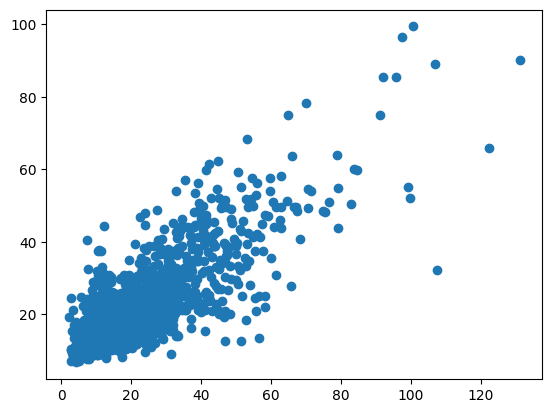

In [10]:
targets1, preds1 = gather_predictions(model1, test_loader, device)
plt.scatter(targets1, preds1)

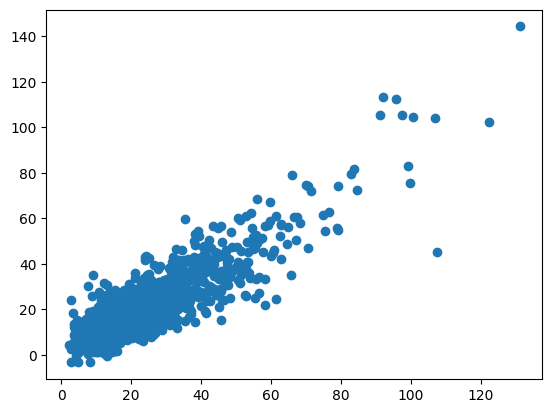

In [11]:
targets2, preds2 = gather_predictions(model2, test_loader, device)
plt.scatter(targets2, preds2)

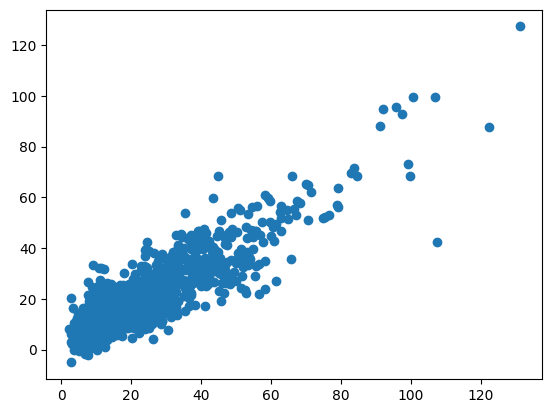

In [13]:
targets3, preds3 = gather_predictions(model3, test_loader, device)
plt.scatter(targets3, preds3)

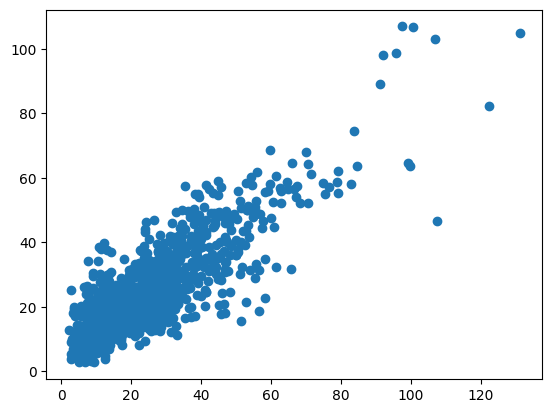

In [14]:
targets4, preds4 = gather_predictions(model4, test_loader, device)
plt.scatter(targets4, preds4)